### Multi class text classifier using ULMFiT

The ULMFiT model utilizes AWD-LSTM architecture that uses multiple LSTM layers with dropout applied to every layer. In this practice, we will use ULMFiT for multi class classification instead of regular binary classification. 

For training and testing the model, we will use a Kaggle dataset that has 20,000 Stack Overflow question titles classified into 20 categories.


### Import Required Libraries

In [1]:
from fastai.text import *
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

In [2]:
# optional
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Optional: use this line if you want to remove Pandas'
# default limit of long text in columns
pd.set_option('display.max_colwidth', None)

In [4]:
# check for cuda
torch.cuda.device_count(), torch.cuda.get_device_name(0)

(1, 'Tesla T4')

In [5]:
# Set GPU device
torch.cuda.set_device(0)

### 1. Load data

##### Data Source:
https://github.com/jacoxu/StackOverflow [1]. 2015NAACL VSM-NLP workshop-"Short Text Clustering via Convolutional Neural Networks"

In [8]:
BASE = 'Keggle_StackOverflowQuestions/'
flabel = 'label_StackOverflow.txt'
ftitle = 'title_StackOverflow.txt'

In [9]:
df_title = pd.read_csv(BASE+ftitle, sep='\t', names=['text'], header=None)
df_title.head(5)

,text
0,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,How do you page a collection with LINQ?
2,Best Subversion clients for Windows Vista (64bit)
3,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,Visual Studio Setup Project - Per User Registry Settings


In [10]:
df_label = pd.read_csv(BASE+flabel, sep='\t', names=['label'], header=None)
df_label.head(5)

,label
0,18
1,18
2,3
3,3
4,7


In [11]:
df = pd.concat([df_label, df_title], axis=1, sort=False)
print('Length of dataset: '+str(len(df.index)))
df.head()

Length of dataset: 20000


,label,text
0,18,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,18,How do you page a collection with LINQ?
2,3,Best Subversion clients for Windows Vista (64bit)
3,3,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,7,Visual Studio Setup Project - Per User Registry Settings


In [12]:
# [Optional] Update label column to show the label text itself, rather than the number.
'''
This step is for visual convenience, and it will not affect the ML model. 

If you decide to run this block of code, FastAI predictions will show as the actual text, instead of just a number. 

Please do not do this the dataset is large.
'''

mapping = {
  1: 'wordpress',
  2: 'oracle',
  3: 'svn',
  4: 'apache',
  5: 'excel',
  6: 'matlab',
  7: 'visual-studio',
  8: 'cocoa',
  9: 'osx',
  10: 'bash',
  11: 'spring',
  12: 'hibernate',
  13: 'scala',
  14: 'sharepoint',
  15: 'ajax',
  16: 'qt',
  17: 'drupal',
  18: 'linq',
  19: 'haskell',
  20: 'magento'
}

df['label'] = df['label'].map(mapping)
df.head()

,label,text
0,linq,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,linq,How do you page a collection with LINQ?
2,svn,Best Subversion clients for Windows Vista (64bit)
3,svn,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,visual-studio,Visual Studio Setup Project - Per User Registry Settings


### 2. Data Preparation

Split train & validation datasets and creat FastAI data bunch

In [13]:
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.2) #If shuffle=False then stratify must be None.

df_trn.shape, df_val.shape

((16000, 2), (4000, 2))

##### Now we will setup our data in the FastAI required format. 

##### We will creat FastAI data bunch, one for Language Model (LM) and another for classifier.

Creating a data bunch automatically results in pre-processing of text, including vocabulary formation and tokenization.

    1. TextLMDataBunch: creates a data bunch for language modelling. In this, labels are completely ignored. Instead, data is processed so that the RNN can learn what word comes next given a starting word. Read the documentation here.
    2. TextClasDataBunch: sets up the data for classification. Labels play a key role here. We can also set the batch size for learning by changing the bs parameter.
    
##### Note in pre-processing
The xx___ tags represent the aspects of language in a way that the computer can understand. The xxbos tag marks the beginning of a sentence. The xxmaj tag is used to imply that the first letter of the next word is capitalized.

In [14]:
# Language model data bunch

datab_lm = TextLMDataBunch.from_df(train_df = df_trn, 
                                   valid_df = df_val, 
                                   path = BASE+'temp')

datab_lm.show_batch()

idx,text
0,fix this virtual host setup ? xxbos xxmaj spring servlet mapping - no css or jsp ! xxbos xxup ajax ( prototype / php ) running 2 ajax process hangs until first one is finished xxbos xxmaj how to accept xxup ref cursor in xxup java without importing xxmaj oracle xxmaj package xxbos xxmaj scala : xxmaj parallel assignment of xxmaj tuples xxbos xxmaj how do i count the number
1,"xxmaj is it possible to detect 32 bit vs 64 bit in a bash script ? xxbos xxmaj how do i set environment variable completion in a bash shell on mac xxbos xxmaj how do i do date math in a bash script on xxup os x xxmaj leopard ? xxbos xxmaj best way to simulate "" group by "" from bash xxbos xxmaj parallelize xxmaj bash xxmaj script xxbos"
2,"? xxbos xxmaj how do i use qmake to build multiple binaries in a single project ? xxbos xxmaj is there an xxmaj oracle xxup sql tool that builds insert statements from a result set ? xxbos xxup ajax cross site scripting between own domains xxbos local vs core contoller xxbos xxunk as "" xxmaj pop - up "" , not as new xxmaj widget ? xxbos i xxmaj need"
3,to session registry after restart ? xxbos xxmaj customizing xxmaj visual xxmaj studio 's xxmaj intellisense xxbos xxmaj how do i create a xxmaj spring 3 + xxmaj tiles 2 webapp using xxup rest - xxunk urls ? xxbos xxmaj how can i make comments like on stackoverflow ? xxbos xxmaj how do you authenticate against an xxmaj active xxmaj directory server using xxmaj spring xxmaj security ? xxbos xxmaj
4,for ? xxbos xxmaj is there a xxmaj scala unit test tool that xxunk well with xxmaj maven ? xxbos xxunk akka xxunk when using restarting container in sbt xxbos xxmaj scala equivalent to xxmaj haskell xxmaj monads xxbos xxmaj but i still need to know how to show user e - mail in xxmaj drupal 5.x profile ( xxunk ) ? xxbos xxmaj how do i reuse xxunk in


In [15]:
# Classifier model data
datab_clas = TextClasDataBunch.from_df(train_df = df_trn, 
                                       valid_df = df_val, 
                                       #test_df = df_test,
                                       path = BASE+'temp',
                                       vocab=datab_lm.train_ds.vocab, bs=24)

datab_clas.show_batch()

text,target
"xxbos xxmaj in apache , if i go to https : / / xxunk , the page itself is over https , but all images / links are http : / / . xxmaj is there way to auto rewrite the html so its all https : / / ?",apache
xxbos i 've a function updating database table using xxmaj spring 's jdbctemplate and for some reason there was exception that connection is read only u can not update any database related changes . xxmaj how to resolve these problem ?,spring
xxbos c : \ xxmaj documents and xxmaj settings \ user \ xxmaj my xxmaj documents \ xxunk \ xxunk xxunk xxunk \ xxunk : xxmaj the module has not been deployed .,ajax
xxbos xxmaj need xxmaj help xxmaj with xxup ajax - xxmaj enabled xxup wcf xxmaj services ( xxmaj please xxmaj look @ xxmaj system . xxunk in xxmaj web . xxmaj config ),ajax
"xxbos xxmaj in xxmaj drupal 6 , is there a way to take a custom field from the latest post to a taxonomy term , and display it in a view ?",drupal


### 3. Create and Train the Language Model

We will create a language model with AWD-LSTM architecture

In [17]:
learn_lm = language_model_learner(datab_lm, AWD_LSTM, drop_mult=0.3) # rerun if fails
# drop_multi is the drop-out proportion in the dropout strategy

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-01
Min loss divided by 10: 2.29E-01


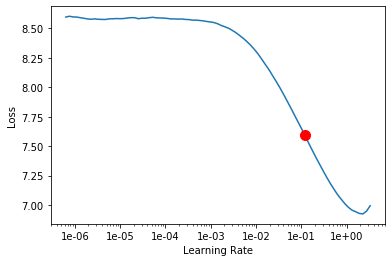

In [20]:
# Now Let’s find the optimal learning rate to train our language model
'''
lr_find() is a built in fast.ai function that runs a few epochs on the model to plot loss, 
and then calculate the minimum gradient.
'''
learn_lm.lr_find() # rerun if fails
learn_lm.recorder.plot(suggestion=True)
min_grad_lr = learn_lm.recorder.min_grad_lr

In [22]:
# we use the obtained optimal learning rate to train the language mode
learn_lm.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,5.304716,4.265568,0.301618,00:08
1,4.455246,4.091677,0.314658,00:07


In [24]:
# unfreezing weights and training the rest of the NN
learn_lm.unfreeze()
learn_lm.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.756818,3.976108,0.328571,00:10
1,3.621818,3.970571,0.331734,00:10


The language model achieved around 33% accuracy, which means that 1 out of 3 times correct. It looks the model predicts the next word relatively well.

In [27]:
# Now we can ask LM to generate text given the initial clue
learn_lm.predict("memory overflow", n_words=10)

'memory overflow in LINQ xxbos Is Oracle rss feed'

In [28]:
# We will save the language model encoder so that we can load it later in our classifier.
learn_lm.save_encoder('lm_ft_enc')

### 4. Using the Language Model to Train the Classifier

We will create the text_classifier_learner with the datab_clas DataBunch and the AWD_LSTM architecture. Then, we will load the language model encoder we saved.

In [30]:
learn_cls = text_classifier_learner(datab_clas, AWD_LSTM, drop_mult=0.5)
learn_cls.load_encoder('lm_ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 1.20E-02


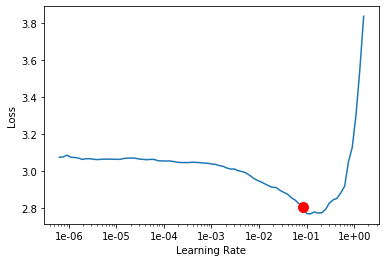

In [32]:
# Now we find the optimal learning rate for classifier model.
learn_cls.lr_find()
learn_cls.recorder.plot(suggestion=True)
min_grad_lr = learn_cls.recorder.min_grad_lr

In [34]:
'''
We will use gradual unfreezing technique to train the classifier. 
In this technique we start by training the last few layers, 
then go backwards and unfreeze and train layers before. 
We use the function learn_cls.freeze_to(-2) to unfreeze the last 2 layers.
'''
learn_cls.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.978760,1.408301,0.605750,00:09
1,1.513259,0.999193,0.749500,00:09


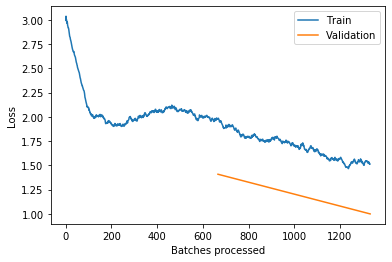

In [35]:
# We will also use learn_cls.recorder.plot_losses() to track our loss function over the epochs.
learn_cls.recorder.plot_losses()

In [37]:
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.180187,0.772005,0.788000,00:11
1,0.905957,0.746189,0.814750,00:11
2,0.797505,0.639564,0.828250,00:11
3,0.794416,0.616703,0.831000,00:11


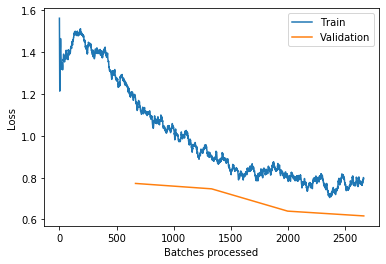

In [38]:
learn_cls.recorder.plot_losses()

In [39]:
# Finally, we unfreeze all layers and train the model at a low learning rate.
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.700037,0.604809,0.834000,00:24
1,0.674963,1.004924,0.838750,00:24
2,0.575452,0.923241,0.843000,00:24
3,0.508327,0.679751,0.843500,00:25


### 5. Analyzing our results

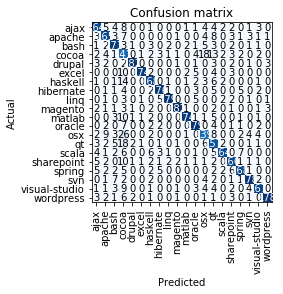

In [41]:
# show the confusion matrix
preds,y,losses = learn_cls.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_cls, preds, y, losses)
interp.plot_confusion_matrix()

In [42]:
# Find the categories that the classifier gets confused on the most.
interp.most_confused()

[('osx', 'cocoa', 26),
 ('cocoa', 'osx', 18),
 ('qt', 'cocoa', 18),
 ('haskell', 'cocoa', 14),
 ('cocoa', 'qt', 13),
 ('excel', 'cocoa', 10),
 ('matlab', 'cocoa', 10),
 ('sharepoint', 'cocoa', 10),
 ('osx', 'apache', 9),
 ('visual-studio', 'cocoa', 9),
 ('ajax', 'cocoa', 8),
 ('apache', 'qt', 8),
 ('osx', 'qt', 8),
 ('apache', 'cocoa', 7),
 ('oracle', 'cocoa', 7),
 ('scala', 'spring', 7),
 ('svn', 'bash', 7),
 ('haskell', 'qt', 6),
 ('qt', 'osx', 6),
 ('scala', 'cocoa', 6),
 ('scala', 'haskell', 6),
 ('spring', 'sharepoint', 6),
 ('wordpress', 'cocoa', 6),
 ('ajax', 'apache', 5),
 ('bash', 'osx', 5),
 ('excel', 'oracle', 5),
 ('hibernate', 'qt', 5),
 ('hibernate', 'spring', 5),
 ('linq', 'hibernate', 5),
 ('linq', 'oracle', 5),
 ('matlab', 'qt', 5),
 ('qt', 'bash', 5),
 ('scala', 'qt', 5),
 ('sharepoint', 'ajax', 5),
 ('spring', 'ajax', 5),
 ('spring', 'cocoa', 5),
 ('spring', 'hibernate', 5),
 ('ajax', 'bash', 4),
 ('ajax', 'osx', 4),
 ('ajax', 'qt', 4),
 ('apache', 'osx', 4),
 ('coco

### 6. Predictions!

Now we can use our model to predict the category of any sentence.

In [43]:
learn_cls.predict("homebrew not working")

(Category cocoa,
 tensor(3),
 tensor([0.0797, 0.1432, 0.0143, 0.2954, 0.0074, 0.0239, 0.0153, 0.0349, 0.0050,
         0.0283, 0.0045, 0.0043, 0.0705, 0.0564, 0.0079, 0.0569, 0.0620, 0.0185,
         0.0282, 0.0432]))

### 7. Export the model

We can export our model using the following function and use it.

It will generate the export.pkl file in directory.

In [44]:
learn_cls.export()

References:

[1] https://medium.com/technonerds/using-fastais-ulmfit-to-make-a-state-of-the-art-multi-label-text-classifier-bf54e2943e83

[2] https://github.com/aditya10/ULMFiT-fastai-text-classifier/blob/master/ULMFiT_tutorial.ipynb